# **Machine Learning Course - Project** 
Andjela Rankovic 24/3107 \
School of Electrical Engineering, University of Belgrade \
August 2025

> **Disclaimer**: This notebook provides a summary of the project's results and is not intended to be run independently. For the complete implementation, please refer to the repository: [https://github.com/rankovicandjela/ProtoPNet](https://github.com/rankovicandjela/ProtoPNet).

This implementation reproduces the results presented in the publication:
> Chen, C., Li, O., Tao, D., Barnett, A., Rudin, C. and Su, J.K., 2019. [This looks like that: deep learning for interpretable image recognition](https://arxiv.org/pdf/1806.10574). Advances in neural information processing systems, 32.

All experimental results, including data preparation, exploratory data analysis, training process, prototype visualizations, and analysis, are documented in the following notebook.

This project uses the Caltech-UCSD Birds-200-2011 ([CUB-200-2011](https://www.kaggle.com/datasets/wenewone/cub2002011)) dataset, an extended version of the original CUB-200 dataset. It contains a total of 11,788 images of birds categorized into 200 species. Each image is richly annotated with a bounding box, part locations (15 per image), and attributes (312 binary labels).

## Environment Setup

In [1]:
# Install dependencies
!pip install torch torchvision torchaudio --quiet
!pip install seaborn scikit-learn kaggle --quiet

import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import pandas as pd
from PIL import Image
import kagglehub
import shutil
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Set global plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Download CUB-200-2011 Dataset

**CUB-200-2011 Dataset Overview**

The Caltech-UCSD Birds-200-2011 (CUB-200-2011) dataset is a widely used benchmark for fine-grained image classification. It contains 11,788 images across 200 bird species, organized into class-based subdirectories. \

Each image is richly annotated with:

- Class labels → mapping each image to one of 200 bird species.

- Train/test split → provided in train_test_split.txt.

- Bounding boxes → precise object locations for cropping or detection tasks.

- Part annotations → locations of 15 bird body parts (e.g., beak, wing, tail).

- Attributes → 312 binary attributes (e.g., color, shape, patterns) annotated via Amazon Mechanical Turk.

For ProtoPNet, we mainly rely on cropped images, class labels, and bounding boxes to better localize birds. The remaining annotations are useful for other tasks but were not required here.

**Data Preparation Instructions**

To prepare the dataset for training and evaluation:

- Download the dataset CUB_200_2011.tgz from the official project website.

- Unpack CUB_200_2011.tgz to extract the dataset folder.

- Crop the images using bounding box information from bounding_boxes.txt.

- Split the cropped images into training and test sets based on train_test_split.txt.

- Place the cropped training images in: \
./datasets/cub200_cropped/train_cropped/

- Place the cropped test images in: \
./datasets/cub200_cropped/test_cropped/

- Augment the training set using the provided img_aug.py script: img_aug.py. The augmented images will be saved in: \
./datasets/cub200_cropped/train_cropped_augmented/

In [6]:
# Install kagglehub if not already installed
!pip install kagglehub --quiet

# Download latest version of dataset
path = kagglehub.dataset_download("wenewone/cub2002011")
print("Dataset downloaded to:", path)

# Set path to the images folder
data_dir = path + "/CUB_200_2011/images"
print("Images directory:", data_dir)

Dataset downloaded to: /home/ubuntu/.cache/kagglehub/datasets/wenewone/cub2002011/versions/7
Images directory: /home/ubuntu/.cache/kagglehub/datasets/wenewone/cub2002011/versions/7/CUB_200_2011/images


## Preparing the Data

### Crop Images Using Bounding Boxes

In this project, we used the bounding box annotations provided in the CUB-200-2011 dataset to crop the images and focus the model on the most relevant regions — the birds themselves.

Bounding boxes specify the x and y coordinates of the top-left corner of the object, along with its width and height. Using these values, each image was cropped to tightly enclose the bird, effectively removing unnecessary background information.

This preprocessing step is important because it reduces noise in the dataset and allows the model to learn more discriminative features from the bird images, which is particularly beneficial when training on a limited number of classes.

In [7]:
# Define base dataset paths
base_dir = os.path.join(path, "CUB_200_2011")
images_dir = os.path.join(base_dir, "images")
bbox_file = os.path.join(base_dir, "bounding_boxes.txt")
images_file = os.path.join(base_dir, "images.txt")

# Save cropped images to a writable location
crop_dir = "./datasets/cub200_cropped"
os.makedirs(crop_dir, exist_ok=True)

# Load bounding boxes + image paths
bbox_df = pd.read_csv(bbox_file, sep=" ", header=None,
                      names=["img_id", "x", "y", "width", "height"])
images_df = pd.read_csv(images_file, sep=" ", header=None,
                        names=["img_id", "rel_path"])
df = pd.merge(bbox_df, images_df, on="img_id")

# Crop images and save them to the writable directory
for _, row in df.iterrows():
    img_path = os.path.join(images_dir, row["rel_path"])
    save_path = os.path.join(crop_dir, row["rel_path"])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    with Image.open(img_path) as img:
        x, y = int(row["x"]), int(row["y"])
        w, h = int(row["width"]), int(row["height"])
        cropped = img.crop((x, y, x + w, y + h))
        cropped.save(save_path)

print(f"Cropped images saved to: {crop_dir}")

Cropped images saved to: ./datasets/cub200_cropped


### Visualize Before vs After Cropping

Using fixed seed = 100


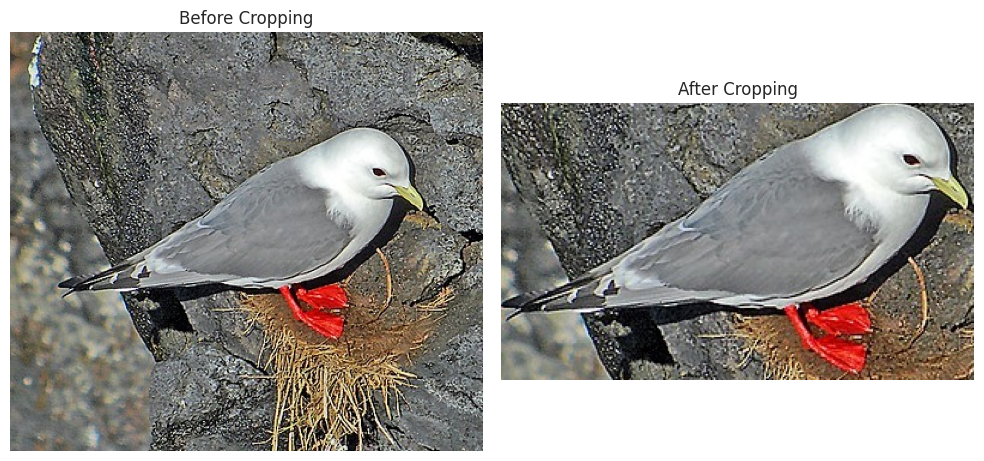

In [ ]:
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
print(f"Using fixed seed = {SEED}")

# === 1. Load bounding boxes + image paths ===
bbox_df = pd.read_csv(bbox_file, sep=" ", header=None,
                      names=["img_id", "x", "y", "width", "height"])
images_df = pd.read_csv(images_file, sep=" ", header=None,
                        names=["img_id", "rel_path"])
df = pd.merge(bbox_df, images_df, on="img_id")

# === 2. Pick one random image (deterministic due to fixed seed) ===
row = df.sample(1, random_state=SEED).iloc[0]

# === 3. Paths and bounding box ===
img_path = os.path.join(images_dir, row["rel_path"])
x, y, w, h = int(row["x"]), int(row["y"]), int(row["width"]), int(row["height"])

# === 4. Open original and cropped image ===
img = Image.open(img_path)
cropped = img.crop((x, y, x + w, y + h))

# === 5. Show side-by-side comparison ===
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title("Before Cropping", fontsize=12)
axes[0].axis("off")

axes[1].imshow(cropped)
axes[1].set_title("After Cropping", fontsize=12)
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Split Cropped Dataset into Train/Test Folders

This step organizes the cropped dataset into **training** and **test** sets according to the official split provided by the CUB-200-2011 dataset, ensuring a clear separation between data used for model training and evaluation.

ProtoPNet uses the provided train/test split of CUB-200-2011 without a separate validation set or cross-validation, as the dataset already comes with a predefined split. Additionally, due to the high computational cost of training ProtoPNet, cross-validation was not performed. The hyperparameters were determined through preliminary experiments and kept constant to ensure consistent results.

In [13]:
split_file = os.path.join(base_dir, "train_test_split.txt")
split_df = pd.read_csv(split_file, sep=" ", header=None, names=["img_id", "is_train"])
df = pd.merge(split_df, images_df, on="img_id")

# Final dataset paths
datasets_root = crop_dir
train_dir = os.path.join(datasets_root, "train_cropped")
test_dir = os.path.join(datasets_root, "test_cropped")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move images
for _, row in df.iterrows():
    src = os.path.join(crop_dir, row["rel_path"])
    dst_root = train_dir if row["is_train"] == 1 else test_dir
    dst = os.path.join(dst_root, row["rel_path"])
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if not os.path.exists(dst):
        shutil.move(src, dst)
    if os.path.exists(src):
        os.remove(src)
    src_parent = os.path.dirname(src)
    try:
        os.removedirs(src_parent)
    except OSError:
        # This occurs if the directory is not empty, so we skip it
        pass

print("Cropped dataset organized into:")
print(f"Train: {train_dir}")
print(f"Test:  {test_dir}")

Cropped dataset organized into:
Train: ./datasets/cub200_cropped/train_cropped
Test:  ./datasets/cub200_cropped/test_cropped


### Top 10 Classes Selection

In this step, we select the top 10 bird species based on the highest total number of images (combined from both training and test sets).

The reason for limiting the dataset to 10 classes instead of using all 200 classes is to make the experiments more computationally efficient and manageable within the available resources. Training ProtoPNet on the entire CUB-200-2011 dataset would require significantly more time and hardware capacity, so focusing on a subset allows us to:

- Reduce computational cost → faster training and testing.

- Simplify result interpretation → easier visualization and analysis of prototypes.

- Validate the approach on a smaller, representative subset before scaling up.

In [19]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"Using fixed seed = {SEED} for reproducibility.")

# === 1. Count images per class ===
def count_images_per_class(directory):
    return Counter([
        folder for folder in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, folder))
    ])

train_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, cls))
}

test_counts = {
    cls: len(os.listdir(os.path.join(test_dir, cls)))
    for cls in os.listdir(test_dir)
    if os.path.isdir(os.path.join(test_dir, cls))
}

# === 2. Compute total images per class (train + test) ===
total_counts = Counter({
    cls: train_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in set(train_counts) | set(test_counts)
})

# === 3. Select top 10 classes (sorted for consistency) ===
top_10_classes = dict(total_counts.most_common(10))
print("\nTop 10 classes to keep (deterministic):")
for cls, total in sorted(top_10_classes.items(), key=lambda x: x[0]):
    print(f"  {cls}: train={train_counts.get(cls, 0)}, test={test_counts.get(cls, 0)}, total={total}")

# === 4. Keep only top classes ===
def keep_only_top_classes(base_path, top_classes):
    for cls in os.listdir(base_path):
        cls_path = os.path.join(base_path, cls)
        if os.path.isdir(cls_path) and cls not in top_classes:
            shutil.rmtree(cls_path)

keep_only_top_classes(train_dir, top_10_classes)
keep_only_top_classes(test_dir, top_10_classes)

print("\nFinal dataset created:")
print(f"Train images → {train_dir}")
print(f"Test images  → {test_dir}")


Using fixed seed = 42 for reproducibility.

Top 10 classes to keep (deterministic):
  002.Laysan_Albatross: train=30, test=30, total=60
  055.Evening_Grosbeak: train=30, test=30, total=60
  061.Heermann_Gull: train=30, test=30, total=60
  094.White_breasted_Nuthatch: train=30, test=30, total=60
  099.Ovenbird: train=30, test=30, total=60
  106.Horned_Puffin: train=30, test=30, total=60
  128.Seaside_Sparrow: train=30, test=30, total=60
  130.Tree_Sparrow: train=30, test=30, total=60
  138.Tree_Swallow: train=30, test=30, total=60
  140.Summer_Tanager: train=30, test=30, total=60

Final dataset created:
Train images → ./datasets/cub200_cropped/train_cropped
Test images  → ./datasets/cub200_cropped/test_cropped


### Data Augmentation

In this setup, **data augmentation** is applied to the training images to artificially increase dataset size and improve model generalization. Using the **Augmentor** library, three types of transformations are performed on each class folder:

* **Rotation** → images are randomly rotated up to ±15° to simulate different viewpoints.
* **Skewing** → images are distorted with a skew of up to 20%, creating perspective variations.
* **Shearing** → small horizontal or vertical shears up to 10° are applied to simulate shape deformations.

Each transformation is combined with a **50% chance of horizontal flipping**, and multiple augmented samples are generated per original image, resulting in a significantly larger and more diverse training set.


In [ ]:
!pip install Augmentor --quiet
import Augmentor
import os
def makedir(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

datasets_root_dir = './datasets/cub200_cropped/'
dir = datasets_root_dir + 'train_cropped/'
target_dir = '../../train_cropped_augmented/'

makedir('./datasets/cub200_cropped/train_cropped_augmented/')
folders = [os.path.join(dir, folder) for folder in next(os.walk(dir))[1]]
target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(dir))[1]]
for i in range(len(folders)):
    fd = folders[i]
    tfd = target_folders[i]
    # rotation
    marker_path = os.path.join(fd,tfd)

    # Skip if already augmented
    if os.path.exists(marker_path):
        print(f"Skipping {fd} -> {tfd} (augmentation already done)")
        continue

    print(f"Augmenting: {fd} -> {tfd}")
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p
    # skew
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.skew(probability=1, magnitude=0.2)  # max 45 degrees
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p
    # shear
    p = Augmentor.Pipeline(source_directory=fd, output_directory=tfd)
    p.shear(probability=1, max_shear_left=10, max_shear_right=10)
    p.flip_left_right(probability=0.5)
    for i in range(10):
        p.process()
    del p

### Visualize Data Augmentation

In the second image (**Augmented 1**), the bird is slightly rotated; in the third image (**Augmented 2**), the original image is horizontally flipped; and in the fourth image (**Augmented 3**), there is a mild perspective skew applied.

Using fixed seed = 42


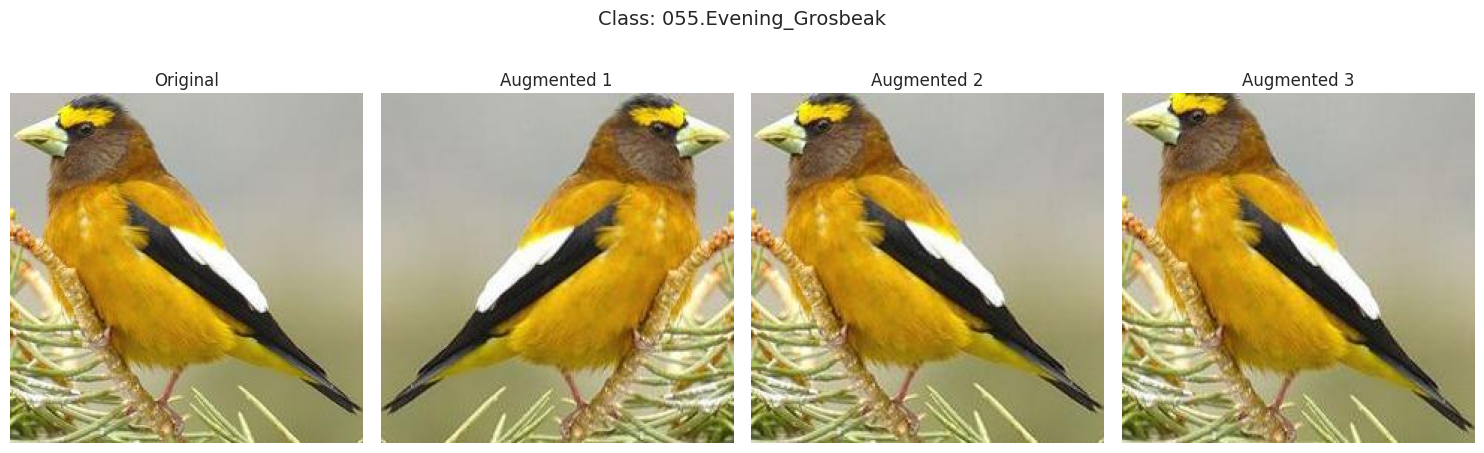

Class: 055.Evening_Grosbeak
Original image: Evening_Grosbeak_0104_37661.jpg
Augmented samples: ['055.Evening_Grosbeak_original_Evening_Grosbeak_0104_37661.jpg_0679f38f-9148-43cf-9cec-0c2105f3e332.jpg', '055.Evening_Grosbeak_original_Evening_Grosbeak_0104_37661.jpg_080f8a58-e349-4235-a933-27a5d5f14594.jpg', '055.Evening_Grosbeak_original_Evening_Grosbeak_0104_37661.jpg_13eb6733-e5d9-4d67-acad-0c85dab9e244.jpg']


In [22]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using fixed seed = {SEED}")

# === 1. Paths ===
train_dir = "./datasets/cub200_cropped/train_cropped/"
aug_dir = "./datasets/cub200_cropped/train_cropped_augmented/"

# === 2. Pick a fixed random class ===
classes = sorted(os.listdir(train_dir))
cls = random.choice(classes)

# === 3. Pick a fixed random original image ===
orig_images = [f for f in os.listdir(os.path.join(train_dir, cls)) 
               if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
orig_img_name = random.choice(orig_images)
orig_img_path = os.path.join(train_dir, cls, orig_img_name)

# === 4. Get augmented images for the same original ===
# Only pick augmentations that correspond to the same original image name
aug_images = [
    f for f in os.listdir(os.path.join(aug_dir, cls)) 
    if f.lower().endswith(('.jpg', '.png', '.jpeg')) 
    and orig_img_name.split('.')[0] in f  # match original image name prefix
]

# Sample up to 3 augmentations deterministically
sample_aug_imgs = sorted(aug_images)[:3]  # deterministic selection

# === 5. Show original + its augmentations ===
fig, axes = plt.subplots(1, len(sample_aug_imgs) + 1, figsize=(15, 5))

# Original image
axes[0].imshow(Image.open(orig_img_path))
axes[0].axis("off")
axes[0].set_title("Original")

# Augmented images
for i, aug_img in enumerate(sample_aug_imgs, start=1):
    aug_img_path = os.path.join(aug_dir, cls, aug_img)
    axes[i].imshow(Image.open(aug_img_path))
    axes[i].axis("off")
    axes[i].set_title(f"Augmented {i}")

plt.suptitle(f"Class: {cls}", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Class: {cls}")
print(f"Original image: {orig_img_name}")
print(f"Augmented samples: {sample_aug_imgs}")

## **Exploratory Data Analysis**

In the exploratory data analysis (EDA) phase, we first counted the number of samples per class in both the training and test sets and verified that the selected top 10 classes were indeed balanced, as expected based on our selection criteria. We then checked for any missing classes in either split and ensured there were no corrupted image files in the dataset. Additionally, we analyzed the distribution of image dimensions by plotting the height and width across the dataset. Finally, we visualized example images from several classes to gain a better understanding of the data characteristics and confirm dataset integrity.

### Dataset Overview & Image Counts

The dataset is split evenly into training and testing sets, with a 50/50 ratio. However, due to the applied data augmentation, the effective size of the training set is significantly increased, providing more diverse samples for model training.

In [24]:
def count_images_per_class(directory):
    """Count number of images in each class folder."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count images per class
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

print("=== Dataset Overview ===")
print(f" • Total classes          : {len(train_counts)}")
print(f" • Total training images  : {sum(train_counts.values())}")
print(f" • Total testing images   : {sum(test_counts.values())}")

# Show a few example classes
print("\n=== Example Class Distribution ===")
for i, (cls, count) in enumerate(list(train_counts.items())[:5]):
    print(f" • {cls}: {count} training images, {test_counts.get(cls, 0)} testing images")

=== Dataset Overview ===
 • Total classes          : 10
 • Total training images  : 300
 • Total testing images   : 300

=== Example Class Distribution ===
 • 002.Laysan_Albatross: 30 training images, 30 testing images
 • 055.Evening_Grosbeak: 30 training images, 30 testing images
 • 061.Heermann_Gull: 30 training images, 30 testing images
 • 094.White_breasted_Nuthatch: 30 training images, 30 testing images
 • 099.Ovenbird: 30 training images, 30 testing images


### Check for Missing Classes in Train/Test Splits or Corrupted Files

In [25]:
missing_in_test = set(train_counts.keys()) - set(test_counts.keys())
missing_in_train = set(test_counts.keys()) - set(train_counts.keys())

if missing_in_test:
    print(f"Classes missing in test set: {len(missing_in_test)}")
else:
    print("No classes are missing in the test set.")

if missing_in_train:
    print(f"Classes missing in train set: {len(missing_in_train)}")
else:
    print("No classes are missing in the train set.")

No classes are missing in the test set.
No classes are missing in the train set.


In [26]:
# Convert counts into DataFrames
train_df = pd.DataFrame.from_dict(train_counts, orient="index", columns=["train_images"])
test_df = pd.DataFrame.from_dict(test_counts, orient="index", columns=["test_images"])

# Merge them into one table
counts_df = train_df.join(test_df, how="outer").fillna(0).astype(int)
counts_df["total_images"] = counts_df["train_images"] + counts_df["test_images"]

print("\n=== Combined Class Counts ===")
print(counts_df.head())


=== Combined Class Counts ===
                             train_images  test_images  total_images
002.Laysan_Albatross                   30           30            60
055.Evening_Grosbeak                   30           30            60
061.Heermann_Gull                      30           30            60
094.White_breasted_Nuthatch            30           30            60
099.Ovenbird                           30           30            60


In [27]:
def check_corrupted_images(root_dir):
    corrupted_files = []
    total_images = 0

    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            total_images += 1
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity without fully loading
            except Exception:
                corrupted_files.append(img_path)

    return corrupted_files, total_images


# Check train set
corrupted_train, total_train = check_corrupted_images(train_dir)
print(f"Train set: {total_train} images scanned.")
print(f"Corrupted or unreadable images in train set: {len(corrupted_train)}")
if corrupted_train:
    print("\nExample corrupted train images:")
    print("\n".join(corrupted_train[:5]))

# Check test set
corrupted_test, total_test = check_corrupted_images(test_dir)
print(f"\nTest set: {total_test} images scanned.")
print(f"Corrupted or unreadable images in test set: {len(corrupted_test)}")
if corrupted_test:
    print("\nExample corrupted test images:")
    print("\n".join(corrupted_test[:5]))

Train set: 300 images scanned.
Corrupted or unreadable images in train set: 0

Test set: 300 images scanned.
Corrupted or unreadable images in test set: 0


### Visualize Class Distribution

The bar chart confirms that the dataset is **perfectly balanced** across the selected 10 classes. Each class contains an **equal number of images** in both the training and testing sets, with **30 images per split**. This ensures that no class dominates the dataset, making the classification task fair and unbiased.

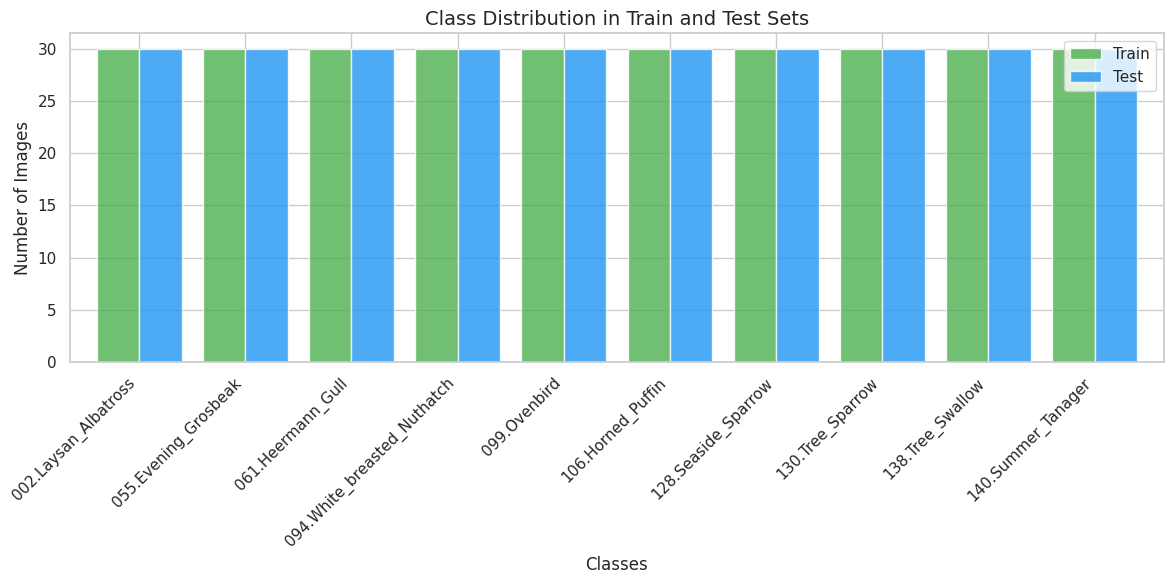

In [28]:
# Plot class distribution for the remaining 10 classes
ax = counts_df[["train_images", "test_images"]].plot(
    kind="bar",
    figsize=(12, 6),
    color=["#4CAF50", "#2196F3"],
    alpha=0.8,
    width=0.8
)

# Title and labels
plt.title("Class Distribution in Train and Test Sets", fontsize=14)
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.xticks(rotation=45, ha="right")

# Add legend
plt.legend(["Train", "Test"])

# Optimize layout
plt.tight_layout()
plt.show()

### Analyze image dimensions (width & height)

These plots provide an overview of the image dimensions within the dataset.

- The scatter plot (top left) shows the spread of image widths and heights, indicating noticeable variability in sizes.

- The boxplot (top right) highlights the median dimensions and variability, revealing a few outliers with unusually large heights.

- The histograms (bottom) display the distributions of widths and heights separately, showing that most images fall within the 200–300 px range for both dimensions, but there is no strict uniformity.

This variability suggests that images may require resizing or scaling during preprocessing to ensure consistency for the model.

In [29]:
def get_image_sizes(root_dir, num_samples=300):
    """Randomly sample images and record their dimensions."""
    sizes = []
    all_images = []

    # Collect all image paths
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                all_images.append(os.path.join(class_path, img_file))

    # Random sampling
    sample_images = random.sample(all_images, min(len(all_images), num_samples))

    # Record image sizes
    for img_path in sample_images:
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)  # (width, height)
        except:
            # Skip unreadable or corrupted images
            continue

    return pd.DataFrame(sizes, columns=["width", "height"])

# Run the function on your train directory
image_sizes_df = get_image_sizes(train_dir, num_samples=2000)

In [30]:
# Basic descriptive statistics
print("=== Image Dimensions Summary ===")
print(image_sizes_df.describe().to_string())

=== Image Dimensions Summary ===
            width      height
count  300.000000  300.000000
mean   263.526667  242.490000
std     83.937961   74.333178
min    101.000000  106.000000
25%    202.000000  190.750000
50%    258.000000  236.500000
75%    319.000000  284.250000
max    476.000000  491.000000


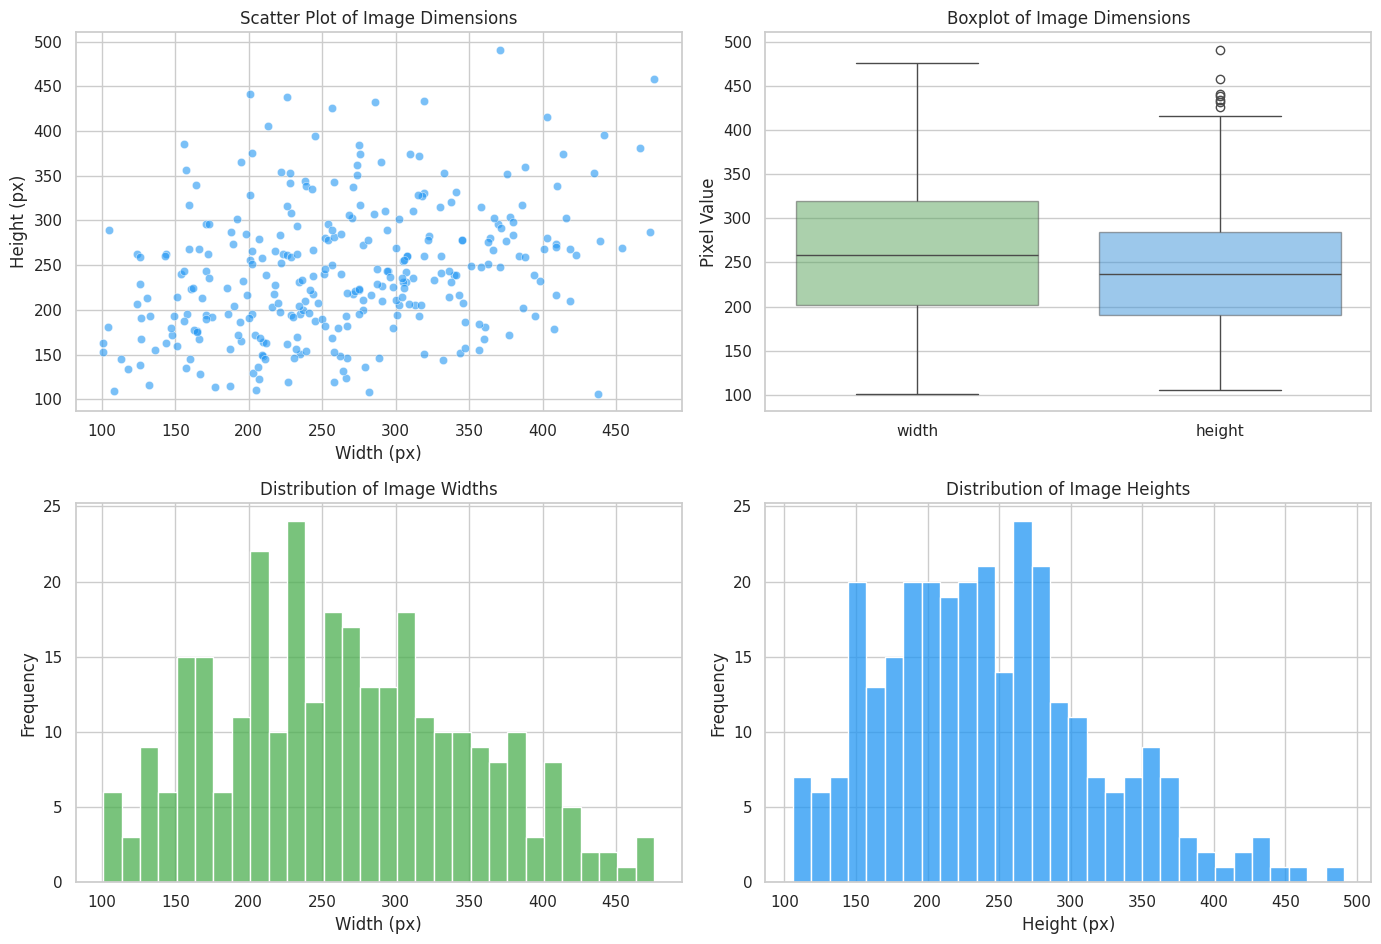

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot: width vs height (top-left)
sns.scatterplot(
    data=image_sizes_df, x="width", y="height",
    alpha=0.6, color="#2196F3", ax=axes[0, 0]
)
axes[0, 0].set_title("Scatter Plot of Image Dimensions")
axes[0, 0].set_xlabel("Width (px)")
axes[0, 0].set_ylabel("Height (px)")

# 2. Boxplot for outliers (top-right) with transparency
sns.boxplot(
    data=image_sizes_df[["width", "height"]],
    palette=["#4CAF50", "#2196F3"],
    ax=axes[0, 1],
    boxprops=dict(alpha=0.5)   # transparency for boxes
)
axes[0, 1].set_title("Boxplot of Image Dimensions")
axes[0, 1].set_ylabel("Pixel Value")

# 3. Histogram of widths (bottom-left)
sns.histplot(
    image_sizes_df["width"], bins=30,
    color="#4CAF50", ax=axes[1, 0]
)
axes[1, 0].set_title("Distribution of Image Widths")
axes[1, 0].set_xlabel("Width (px)")
axes[1, 0].set_ylabel("Frequency")

# 4. Histogram of heights (bottom-right)
sns.histplot(
    image_sizes_df["height"], bins=30,
    color="#2196F3", ax=axes[1, 1]
)
axes[1, 1].set_title("Distribution of Image Heights")
axes[1, 1].set_xlabel("Height (px)")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Display random sample images from random classes

Using fixed seed = 35


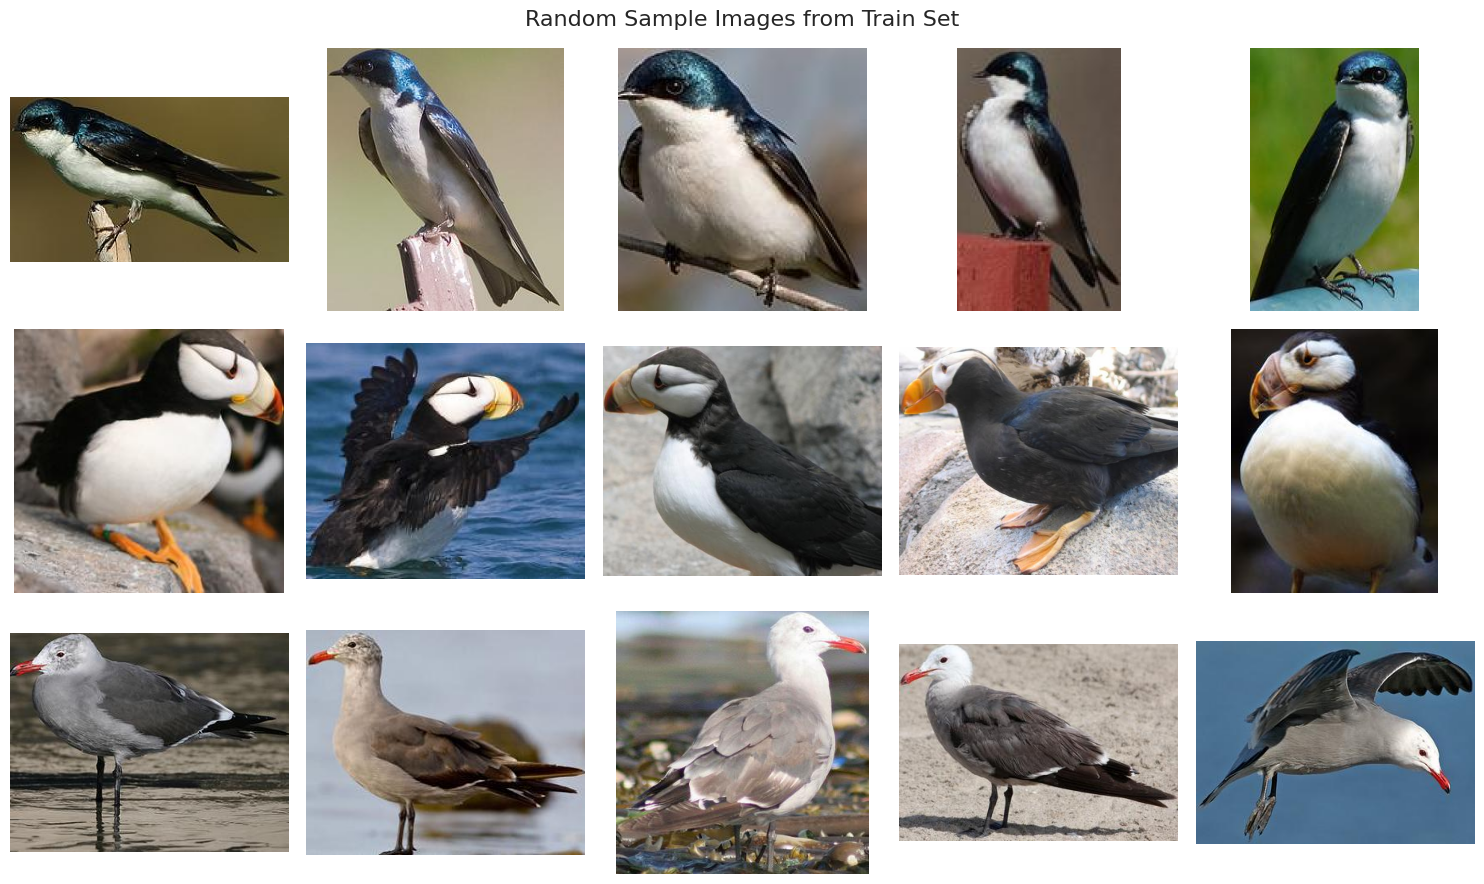

In [32]:
SEED = 35
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using fixed seed = {SEED}")

# === 1. Function to show random images ===
def show_random_images(root_dir, num_classes=3, num_images=5):
    """Display a grid of random images from random classes with reproducibility."""
    # Pick random classes (deterministic due to seed)
    class_names = random.sample(sorted(os.listdir(root_dir)), num_classes)
    plt.figure(figsize=(num_images * 3, num_classes * 3))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(root_dir, class_name)
        image_files = sorted([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

        # Pick random images for each class (deterministic due to seed)
        images = random.sample(image_files, min(len(image_files), num_images))

        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)

            # Open and display image
            img = Image.open(img_path)
            plt.subplot(num_classes, num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis("off")

            # Label class name on the left of the row
            if j == 0:
                plt.ylabel(class_name, fontsize=12, rotation=0, labelpad=40)

    plt.suptitle("Random Sample Images from Train Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# === 2. Show 3 random classes with 5 random images each ===
show_random_images(train_dir, num_classes=3, num_images=5)


# Baseline Model

**Baseline Model Design**

The baseline model is built using a pretrained **VGG19** network as a feature extractor combined with a **logistic regression classifier** on top. Instead of training the entire deep neural network from scratch, we leverage **transfer learning** by using VGG19, which was trained on ImageNet and already captures rich, general-purpose visual features. We remove the final classification head of VGG19 and extract embeddings from its last convolutional layer, resulting in 2048-dimensional feature vectors for each image.

These extracted features are then fed into a multinomial logistic regression classifier, which learns to distinguish between the 10 bird classes in our dataset. Finally, we evaluate the model on the test set using classification accuracy and a detailed classification report.

In [33]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

This code defines the **image preprocessing pipeline** required for using a pretrained **VGG19** model. First, all images are resized to **224×224 pixels** to match the model’s expected input size. Then, they are converted into **PyTorch tensors** and their pixel values are scaled to the **\[0,1]** range. Finally, the images are **normalized** using the **mean** and **standard deviation** of the ImageNet dataset, ensuring that the input distribution matches what the pretrained network was originally trained on. This improves performance and stability during feature extraction and classification.

In [39]:
# Dataset paths
train_dir = "./datasets/cub200_cropped/train_cropped_augmented"
test_dir = "./datasets/cub200_cropped/test_cropped"

# Image transforms (matching pretrained ResNet input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

This section loads the training and testing datasets using ImageFolder, which automatically assigns labels based on folder names and applies the defined image transformations. The DataLoader then groups the data into batches of 32 images for efficient processing.

In [41]:
# Load train and test datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train size: 8309, Test size: 300
Classes: ['002.Laysan_Albatross', '055.Evening_Grosbeak', '061.Heermann_Gull', '094.White_breasted_Nuthatch', '099.Ovenbird', '106.Horned_Puffin', '128.Seaside_Sparrow', '130.Tree_Sparrow', '138.Tree_Swallow', '140.Summer_Tanager']


In this part, we load a pretrained VGG19 model from torchvision to leverage its learned feature representations. The model is set to evaluation mode using resnet.eval(), which freezes its parameters to prevent further training. We then remove the final classification layer and keep only the feature extractor part, which outputs high-level image embeddings.

In [42]:
# Load pretrained ResNet50
resnet = models.vgg19(pretrained=True)
resnet.eval()  # freeze model

# Remove the classification head — keep only feature extractor
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to("cuda" if torch.cuda.is_available() else "cpu")

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In this setup, the pretrained VGG19 model is used to extract **feature embeddings** from the images in both the training and test sets. The images are passed through the network, and the resulting feature maps are **flattened** into 1D vectors. These embeddings (`train_features` and `test_features`) serve as compact, high-level image representations that are later used for training and evaluating a separate classifier.

In [43]:
def extract_features(dataloader):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = feature_extractor(images)       # shape: (batch, 2048, 1, 1)
            features = features.view(features.size(0), -1)  # flatten to (batch, 2048)

            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract embeddings
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

print("Feature shape:", train_features.shape)

Feature shape: (8309, 25088)


In this step, a **multinomial logistic regression** model is trained on the extracted VGG19 feature embeddings from the training set. The trained classifier is then used to predict the labels of the test set, and its performance is evaluated using **accuracy** and a **classification report**, which provides precision, recall, and F1-score for each class.

In [45]:
clf = LogisticRegression(max_iter=500, solver="lbfgs", multi_class="multinomial")
clf.fit(train_features, train_labels)

# Predict on test set
y_pred = clf.predict(test_features)

# Evaluate
print("Accuracy:", accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred, target_names=train_dataset.classes))

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.95
                             precision    recall  f1-score   support

       002.Laysan_Albatross       1.00      0.90      0.95        30
       055.Evening_Grosbeak       1.00      1.00      1.00        30
          061.Heermann_Gull       0.94      1.00      0.97        30
094.White_breasted_Nuthatch       0.88      0.97      0.92        30
               099.Ovenbird       0.93      0.93      0.93        30
          106.Horned_Puffin       1.00      0.97      0.98        30
        128.Seaside_Sparrow       0.88      0.93      0.90        30
           130.Tree_Sparrow       0.96      0.90      0.93        30
           138.Tree_Swallow       0.93      0.90      0.92        30
         140.Summer_Tanager       1.00      1.00      1.00        30

                   accuracy                           0.95       300
                  macro avg       0.95      0.95      0.95       300
               weighted avg       0.95      0.95      0.95       300



The baseline model achieved an overall accuracy of 95%, which indicates strong performance on the test set. The precision, recall, and F1-scores are consistently high across most classes, showing that the model can correctly identify bird species with minimal misclassification.

# ProtoPNet

**Main Idea of ProtoPNet**

The Prototypical Part Network (ProtoPNet) introduces interpretable image classification by combining deep learning with prototype-based reasoning. Instead of making predictions purely from high-dimensional embeddings, ProtoPNet learns a set of prototypes — representative parts of training images — and bases its classification on their similarity to parts of the input image.

The image below (taken from the original ProtoPNet paper [Chen et al., 2019](https://arxiv.org/pdf/1806.10574)) illustrates this idea:

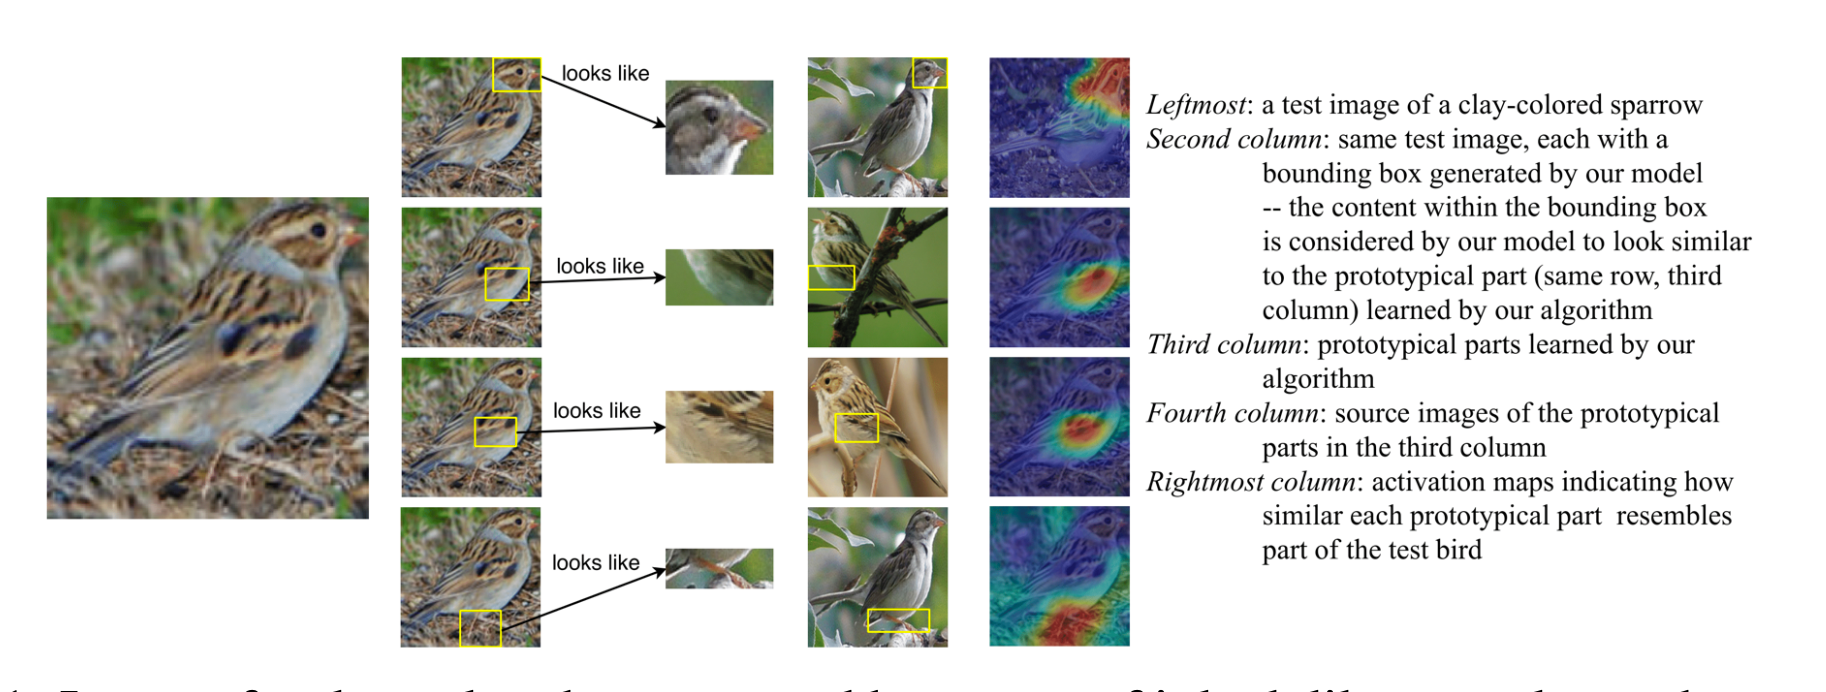

- The leftmost column shows a test image of a clay-colored sparrow.

- The second column highlights regions in the test image that the model considers most similar to specific learned prototypes.

- The third column shows the prototypical parts learned during training.

- The fourth column presents the source images from which these prototypes originate.

- The rightmost column displays activation maps, indicating how strongly each part of the test image resembles the corresponding prototype.

This mechanism allows the model to explain its predictions by saying, *“I classify this as a clay-colored sparrow because this region of the bird looks like this learned prototype.”* It bridges the gap between accuracy and interpretability, making the decision-making process more transparent.

### Model Architecture

The **ProtoPNet** architecture builds upon a standard convolutional neural network (**CNN**) backbone, such as **VGG**, **ResNet**, or **DenseNet**, and augments it with a **prototype layer** followed by a **linear classification layer**. While different backbones can be used, in this project we utilize **VGG19**. The network can be divided into three main components:


### **1. Convolutional Feature Extractor**  
A pretrained **VGG19** model is used to extract **high-level feature maps** from the input images. These feature maps capture essential semantic information about different parts of the image but are not yet directly interpretable. At this stage, the network focuses on learning robust representations, which will later be compared against learned prototypes.

### **2. Prototype Layer**  
The core innovation of ProtoPNet lies in the introduction of a **prototype layer** consisting of **learnable prototypes**. Each prototype represents a **specific visual pattern** (e.g., *“the beak of a bird”*) and corresponds to a **representative patch** from one of the training images.  

To determine how similar a patch from the input image is to a given prototype, the network employs **generalized convolution**, which replaces the standard dot-product similarity with the **negative squared L₂ distance**. For each patch feature vector $\mathbf{z}$ and prototype vector $\mathbf{p}$, the squared L₂ distance is computed as:

$d^2(\mathbf{z}, \mathbf{p}) = \|\mathbf{z} - \mathbf{p}\|_2^2 = \sum_{i=1}^{D} (z_i - p_i)^2$

where **D** represents the **dimensionality of the feature vectors** $\mathbf{z}$ and $\mathbf{p}$. A **small L₂ distance** directly implies that the patch is **very similar** to the prototype, while larger distances indicate dissimilarity. These distances are then transformed into similarity scores, which quantify how closely different parts of the image match known prototypes. This approach makes the model’s reasoning more **intuitive** and **interpretable**, as classification decisions are based on comparisons with prototypical visual patterns rather than opaque feature activations.


### **3. Classification Layer**  
Once the similarity scores are computed, a **fully connected classification layer** combines them to produce the final prediction. The weights connecting prototypes to classes are **constrained** so that each prototype **positively contributes** only to its corresponding class while having **little to no influence** on unrelated classes. This ensures that the network’s decisions remain faithful to the prototypes and avoids introducing misleading associations.


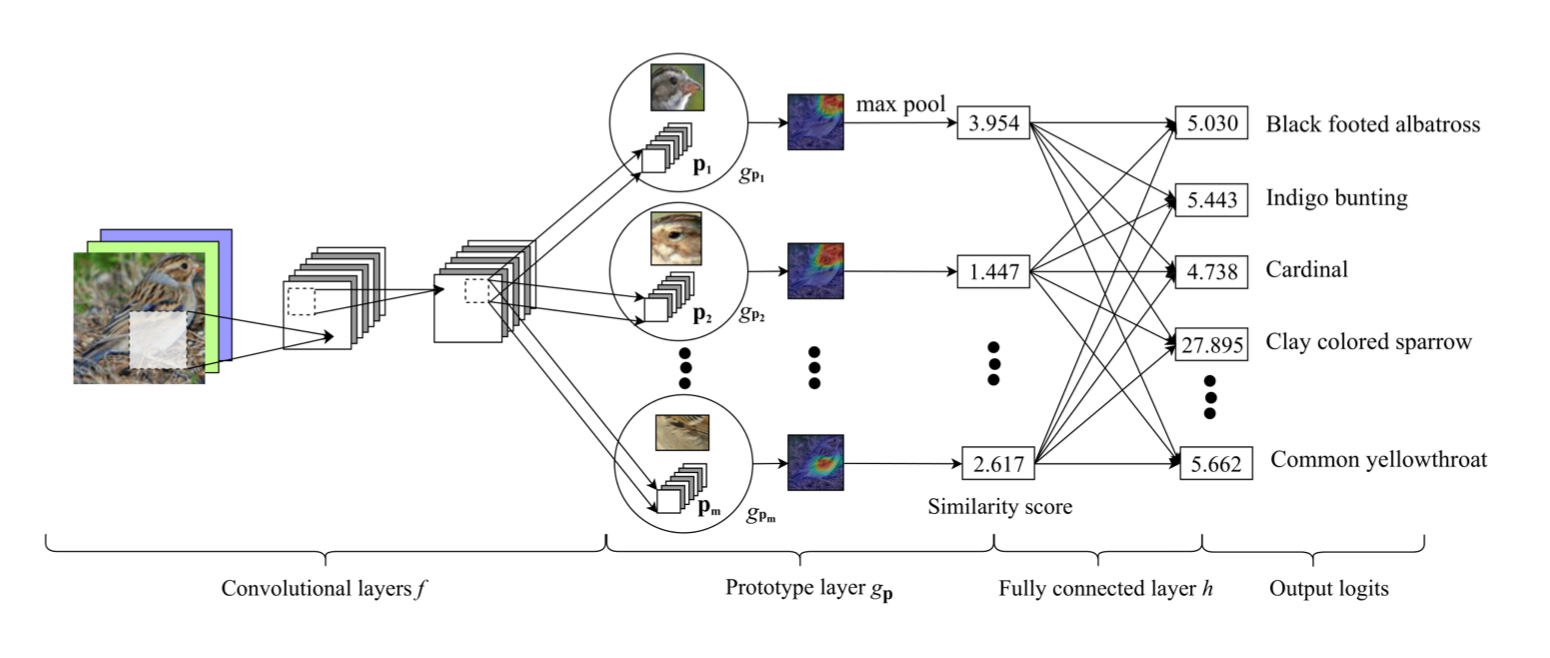

## **Learning and Optimization Process**

The training of **ProtoPNet** is designed to jointly learn meaningful prototypes, an effective feature extractor, and an interpretable classification strategy. The optimization process consists of **three main stages**.


**Stage 1 – Joint Training**

In the first stage, the network jointly learns the parameters of the **CNN feature extractor**, the positions of the **prototypes**, and the weights of the **classification layer**. To achieve this, ProtoPNet minimizes a **combined loss function**:

$$
L = L_{\text{CE}} + \lambda_1 \cdot L_{\text{clst}} + \lambda_2 \cdot L_{\text{sep}}
$$

Here, $L_{\text{CE}}$ is the **cross-entropy loss**, which ensures that the model learns to correctly classify the images. The **clustering loss** $(L_{\text{clst}})$ encourages each prototype to be **close** to at least one **feature patch** of its **own class**, effectively pushing prototypes toward representative regions within their class. Conversely, the **separation loss** $(L_{\text{sep}})$ forces prototypes to be **far away** from feature patches belonging to **other classes**, ensuring that each prototype captures class-specific patterns.  

This combination of losses ensures that each prototype specializes in representing a **specific, discriminative part** of a single class — for example, the beak of a bird, the wing pattern of a swallow, or other distinctive visual features.


**Stage 2 – Prototype Projection**

After the joint training stage, the learned prototypes are **projected** onto **real feature patches** from the training set. In this step, each prototype is **snapped** to the **closest latent patch** belonging to its **own class**.  

This process guarantees that **every prototype corresponds to an actual, interpretable image region** rather than an artificial latent vector. By grounding prototypes in real examples, the interpretability of the model is significantly improved. Each prototype can now be visualized as a real image patch from the training data, allowing us to better understand the reasoning behind the model’s predictions.


**Stage 3 – Last Layer Optimization**

In the final stage, the prototypes and convolutional backbone are **frozen**, and only the **classification layer** is fine-tuned. This step ensures that the linear layer optimally leverages the learned similarity scores between prototypes and input images.  

Furthermore, by constraining the weights of the last layer, the model enforces that **each prototype positively contributes only to its corresponding class** while having minimal or no influence on unrelated classes. This further enhances the interpretability and reliability of the model.


**Instructions for training the model:**
1. In settings.py, provide the appropriate strings for data_path, train_dir, test_dir,
train_push_dir: 
- data_path is where the dataset resides
-- if you followed the instructions for preparing the data, data_path should be "./datasets/cub200_cropped/" 
- train_dir is the directory containing the augmented training set
-- if you followed the instructions for preparing the data, train_dir should be data_path + "train_cropped_augmented/" 
- test_dir is the directory containing the test set
-- if you followed the instructions for preparing the data, test_dir should be data_path + "test_cropped/" 
- train_push_dir is the directory containing the original (unaugmented) training set
-- if you followed the instructions for preparing the data, train_push_dir should be data_path + "train_cropped/" 
2. Run main.py

In [48]:
!python3 main.py

0
training set size: 8309
push set size: 300
test set size: 300
batch size: 40
start training
epoch: 	0
	warm
	train
	time: 	9.740630149841309
	cross ent: 	1.5339287118269846
	cluster: 	1.8325500902003393
	separation:	1.736778563246704
	avg separation:	10.247512927422157
	accu: 		56.119870020459736%
	l1: 		550.0
	p dist pair: 	19.50064468383789
	test
	time: 	0.4852597713470459
	cross ent: 	1.289079596598943
	cluster: 	0.2665833756327629
	separation:	0.2536545768380165
	avg separation:	9.484561125437418
	accu: 		60.66666666666667%
	l1: 		550.0
	p dist pair: 	19.50064468383789
epoch: 	1
	warm
	train
	time: 	9.46129822731018
	cross ent: 	0.502119595471483
	cluster: 	0.09379648170075737
	separation:	0.2456214871400824
	avg separation:	9.37400496006012
	accu: 		87.25478396919003%
	l1: 		550.0
	p dist pair: 	18.880815505981445
	test
	time: 	0.4884641170501709
	cross ent: 	0.8205377409855524
	cluster: 	0.1269151009619236
	separation:	0.1976837913195292
	avg separation:	8.992686907450357
	accu

### **Learning Curves and Overfitting Analysis**

**1. Training and Test Loss**

The **training loss** decreases sharply within the first few epochs and reaches nearly zero by around **epoch 10**, indicating that the model learns to fit the training data very effectively. In contrast, the **test loss** decreases initially but stabilizes around **0.4–0.5** after approximately **epoch 8**. This plateau suggests that the model stops improving on unseen data beyond this point, even though it continues to optimize on the training set.

**2. Training and Test Accuracy**

**Training accuracy** quickly approaches **100%**, while **test accuracy** plateaus around **91–92%** after roughly **10 epochs**. This divergence between training and test performance indicates **mild overfitting**: the network becomes increasingly specialized to the training data while providing only incremental gains on the test set.

**3. Overfitting and Regularization**

ProtoPNet inherently mitigates severe overfitting due to its architectural design and loss formulation:

- **Prototype constraints** ensure that each prototype contributes **positively** only to its own class.
- **Clustering and separation losses** enforce **class-specific representation learning**.
- **Prototype projection** snaps prototypes to **real training patches**, acting as an **implicit regularization** step.

However, despite these mechanisms, the gap between training and test performance suggests that **additional regularization techniques** could further improve generalization, such as:

- **Early stopping**: halting training once the test loss stops decreasing.
- **Dropout** or **weight decay**: reducing over-specialization of prototypes.

In this project, **early stopping** was **not applied**, as the original ProtoPNet implementation also trains for a **fixed number of epochs**.  
Nevertheless, while there are **signs of overfitting**, it is worth noting that the **test loss remained relatively stable** after approximately **epoch 10**, meaning that continued training did not significantly worsen generalization. Introducing **early stopping** could be considered in future experiments to potentially improve efficiency without sacrificing accuracy.


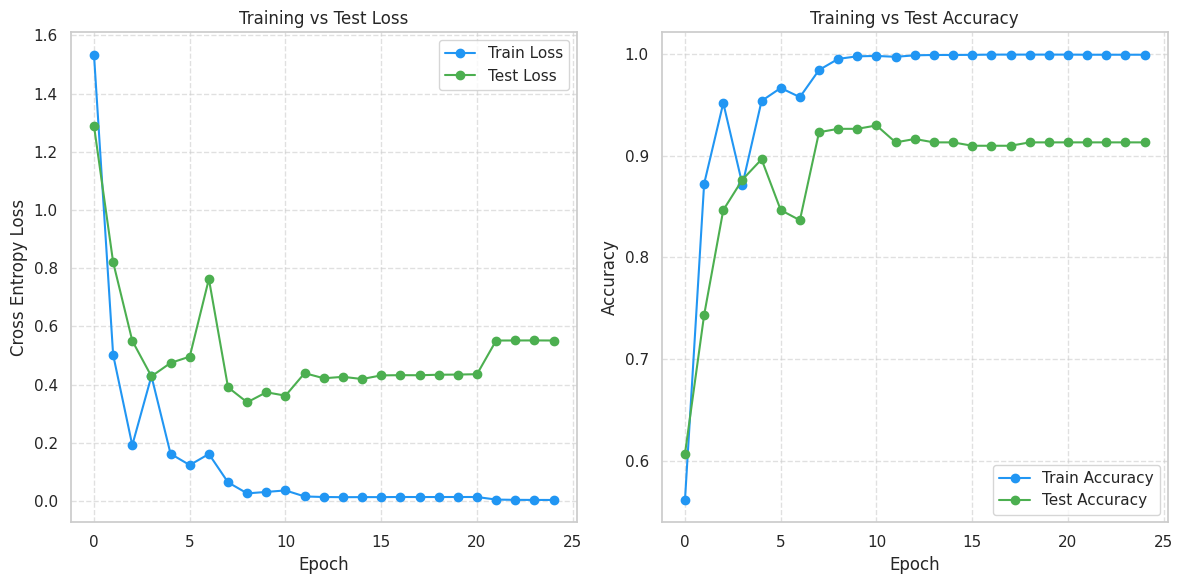

In [4]:
import re
import matplotlib.pyplot as plt

# Path to your training log file
log_file = "./results.txt"  # <-- replace with your log file path

# Containers for metrics
epochs = []
train_loss = []
test_loss = []
train_accu = []
test_accu = []

# Read the log file
with open(log_file, "r") as f:
    log_text = f.read()

# Split the log into blocks per epoch
epoch_blocks = re.split(r"epoch:", log_text)[1:]

for block in epoch_blocks:
    # Extract epoch number
    epoch_num_match = re.match(r"\s*(\d+)", block)
    if epoch_num_match:
        epochs.append(int(epoch_num_match.group(1)))

    # === TRAIN LOSS ===
    train_cross_ent = re.search(r"train.*?cross ent:\s+([\d\.]+)", block, re.S)
    if train_cross_ent:
        train_loss.append(float(train_cross_ent.group(1)))
    else:
        train_loss.append(None)

    # === TRAIN ACCURACY ===
    train_acc_match = re.search(r"train.*?accu:\s+([\d\.]+)", block, re.S)
    if train_acc_match:
        acc = float(train_acc_match.group(1))
        if acc > 1:  # Convert percentage if needed
            acc /= 100.0
        train_accu.append(acc)
    else:
        train_accu.append(None)

    # === TEST LOSS ===
    test_cross_ent = re.search(r"test.*?cross ent:\s+([\d\.]+)", block, re.S)
    if test_cross_ent:
        test_loss.append(float(test_cross_ent.group(1)))
    else:
        test_loss.append(None)

    # === TEST ACCURACY ===
    test_acc_match = re.search(r"test.*?accu:\s+([\d\.]+)", block, re.S)
    if test_acc_match:
        acc = float(test_acc_match.group(1))
        if acc > 1:
            acc /= 100.0
        test_accu.append(acc)
    else:
        test_accu.append(None)

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o", color="#2196F3")
plt.plot(epochs, test_loss, label="Test Loss", marker="o", color="#4CAF50")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accu, label="Train Accuracy", marker="o", color="#2196F3")
plt.plot(epochs, test_accu, label="Test Accuracy", marker="o", color="#4CAF50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [50]:
!python3 global_analysis.py \
    -modeldir saved_models/vgg19/003/ \
    -model 20push0.9133.pth

load model from saved_models/vgg19/003/20push0.9133.pth
find nearest patches
batch 0
batch 1
batch 2
	find nearest patches time: 	47.745023012161255
find nearest patches
batch 0
batch 1
batch 2
	find nearest patches time: 	41.49751424789429


### Global Analysis of Prototypes

global_analysis.py is used for interpreting a trained prototype-based neural network (like ProtoPNet). Instead of just giving accuracy numbers, it digs into the model’s internal reasoning. Specifically, it:

- Looks at all prototypes that the network has learned during training. Each prototype is essentially a small image patch stored in the model, representing a “concept” useful for classification.

- Finds the nearest input patches from the dataset that match each prototype most strongly. This helps visualize what part of real images the prototype corresponds to.

- Provides global interpretability by showing the collection of prototypes across the entire model, so you can understand what concepts the model relies on when making predictions.

In short, it’s a tool for analyzing and explaining the overall behavior of the model through its prototypes, rather than just evaluating predictions on individual images.

Instructions for finding the nearest patches to each prototype:
1. Run global_analysis.py and supply the following arguments:

- -gpuid is the GPU device ID(s) you want to use (optional, default '0')

- -modeldir is the directory containing the model you want to analyze

- -model is the filename of the saved model you want to analyze

### Local Analysis of Prototypes

Local analysis provides instance-level interpretability, focusing on how a trained prototype-based model arrives at a specific prediction. For each input image, the analysis identifies which prototypes were activated, where they matched within the image, and how strongly they contributed to the final decision.

This yields:

- Heatmaps highlighting image regions where prototypes align.

- Nearest-patch comparisons showing the most similar training patches for each activated prototype.

- Contribution scores quantifying the positive or negative influence of prototypes on the prediction.

Through these outputs, local analysis offers a transparent, case-based explanation of model decisions, demonstrating which concepts mattered most and why.

In [6]:
!python3 local_analysis.py -modeldir='./saved_models/vgg19/003/' -model='20push0.9133.pth' -imgdir './local_analysis/' -img 'Laysan_Albatross_0001_545.jpg' -imgclass 0

load model from ./saved_models/vgg19/003/20push0.9133.pth
model base architecture: vgg19
experiment run: 003/
Prototypes are chosen from 10 number of classes.
Their class identities are: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
All prototypes connect most strongly to their respective classes.
0 (0, 0)
Predicted: 0
Actual: 0
image index 0 in batch
Most activated 10 prototypes of this image:
top 1 activated prototype for this image:
prototype index: 9
prototype class identity: 0
activation value (similarity score): 1.367122769355774
last layer connection with predicted class: 1.1426408290863037
most highly activated patch of the chosen image by this prototype:
most highly activated patch by this prototype shown in the original image:
prototype activation map of the chosen image:
-------------------------------------------------

### Interpretation of Local Analysis Results

When examining local analyses across all 10 classes, many prototypes appear visually similar and often correspond to recurring patterns in the dataset. This suggests that the model may have learned redundant prototypes, where different prototypes capture nearly the same concept. On one hand, this redundancy can indicate overfitting, as the model repeatedly memorizes dominant features rather than diversifying its representation. On the other hand, it may also reflect that certain visual cues are genuinely the most discriminative across multiple classes.

**Recommendation:** Future work could address prototype redundancy by applying prototype pruning methods or by encouraging greater diversity in the learned prototypes through regularization strategies. Additionally, training on a more varied dataset could reduce overfitting and ensure that prototypes capture a broader set of meaningful concepts.

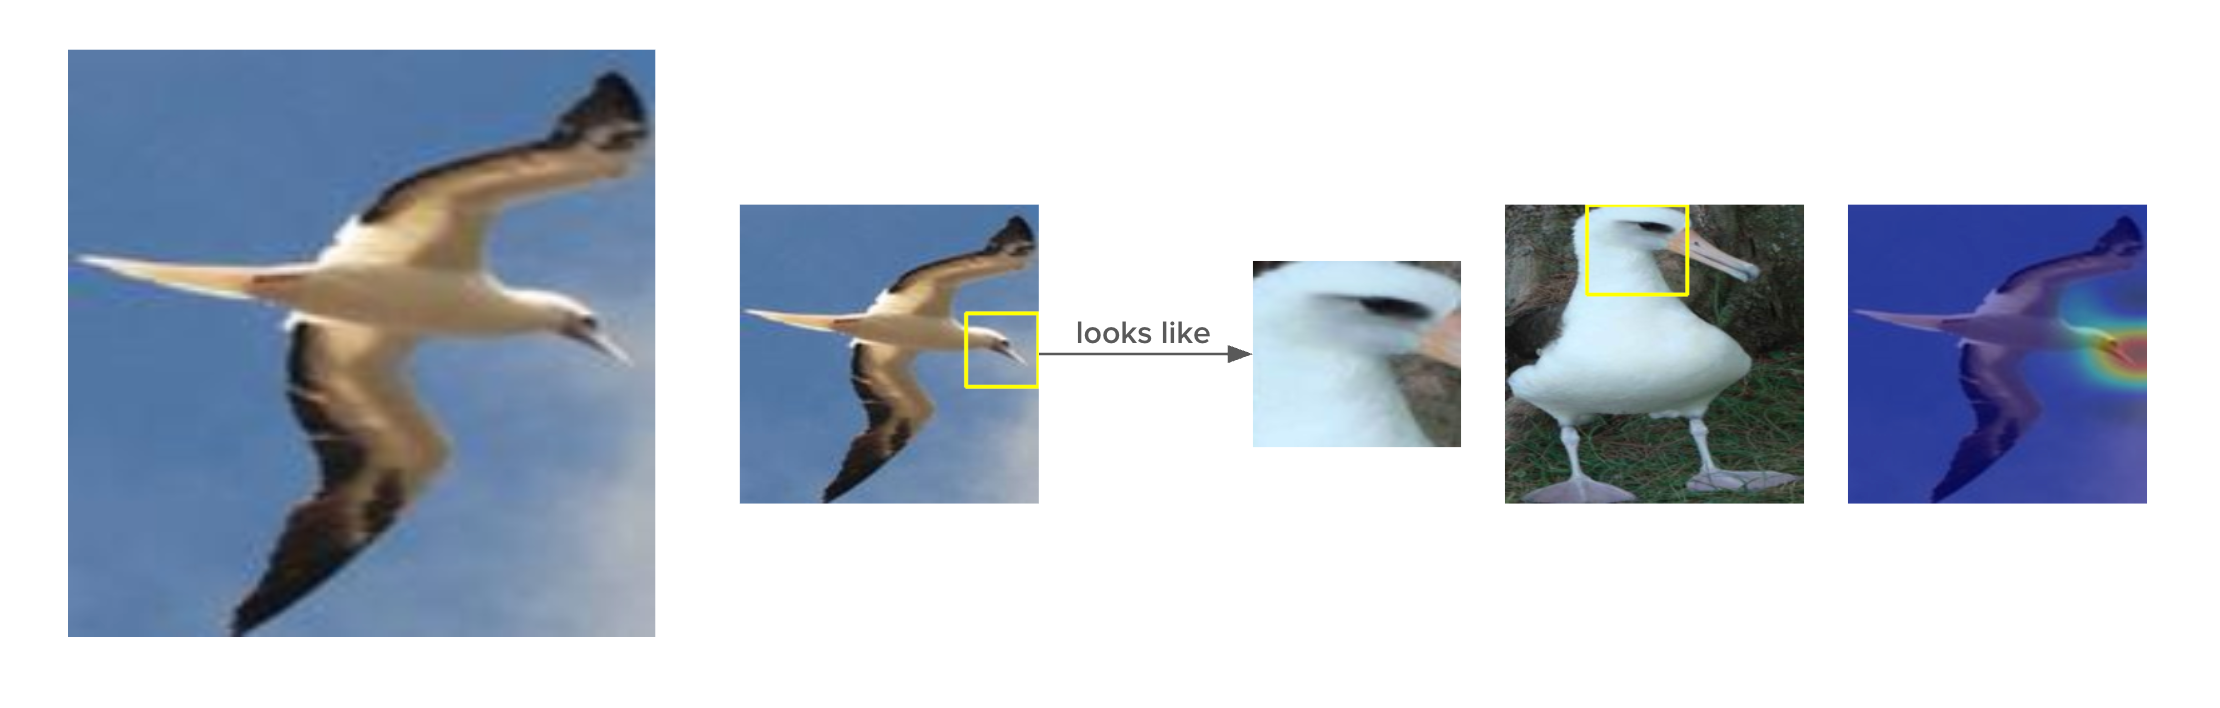

### Comparison with Reported Results

In the original ProtoPNet paper, the authors report classification accuracies of 78.0 ± 0.2% for the baseline VGG-19 model and 75.1 ± 0.4% for ProtoPNet on the same backbone. In contrast, my experiments yielded substantially higher results: a baseline VGG-19 accuracy of 95% and a ProtoPNet accuracy of 91.33%.

The discrepancy in absolute numbers is likely due to differences in datasets, preprocessing, and experimental setup. However, the relative trend is consistent with the paper: ProtoPNet performs slightly worse than the baseline. This decrease in accuracy is an expected trade-off, as ProtoPNet constrains the model to make decisions based on a limited set of interpretable prototypes. By enforcing this case-based reasoning, the model sacrifices some raw discriminative power but gains transparency and interpretability, enabling users to understand why predictions are made.